In [113]:
# loading libraries 
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2
import sys
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor
from os.path import join, dirname
import os 
from io import BytesIO
import copy
import seaborn_image as isns

def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.35]])
        img[m] = color_mask
    ax.imshow(img)

def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    
def show_points(coords, labels, ax, marker="*", color="green", marker_size=375, ):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color=color, marker=marker, s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker=marker, s=marker_size, edgecolor='white', linewidth=1.25)   
    
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))    

def apply_mask(np_image, mask, ax):
    res = cv2.bitwise_and(np_image,np_image,mask = mask)
    ax.imshow(res)

In [2]:
filepath = "../../data/20240109_155650751.jpg"
image = cv2.imread(filepath)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

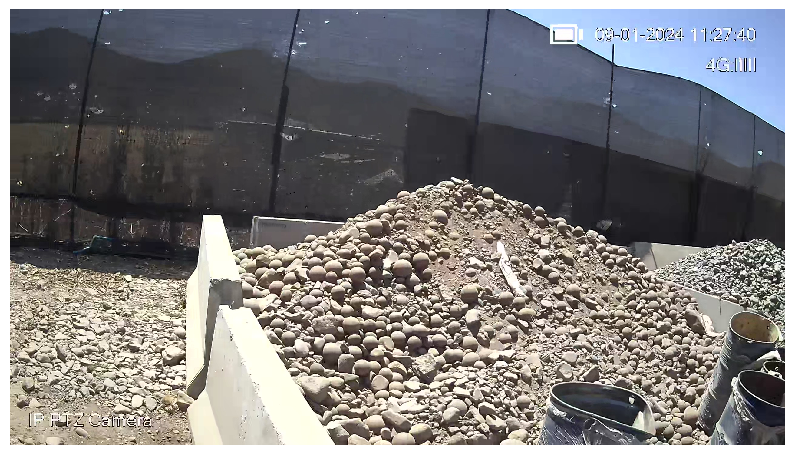

In [3]:
plt.figure(figsize=(10,10))
plt.imshow(image)
plt.axis('off')
plt.show()

In [4]:
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
MODEL_TYPE = "vit_h"
CHECKPOINT_PATH  = "/dagster/apps/dagster_easyscraptracker/dagster_easyscraptracker/models/sam_vit_h_4b8939.pth"

sam = sam_model_registry[MODEL_TYPE](checkpoint=CHECKPOINT_PATH)
sam.to(device=DEVICE)

mask_predictor = SamPredictor(sam)

Select region of interest

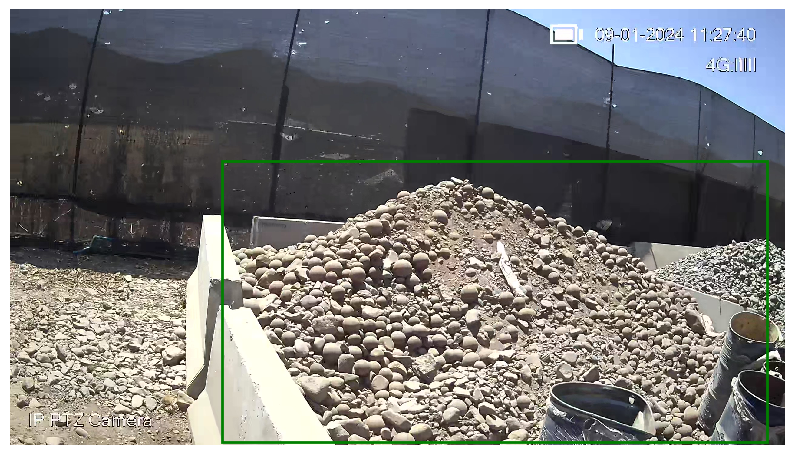

In [5]:
box = np.array([700, 500, 2500, 1430])

plt.figure(figsize=(10,10))
plt.imshow(image)
#x0, y0 = box[0], box[1]
#w, h = box[2] - box[0], box[3] - box[1]
# ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))  
show_box(box, plt.gca())
plt.axis('off')
plt.show()

In [6]:
mask_predictor.set_image(image)

In [7]:
masks, scores, logits = mask_predictor.predict(
    box=box,
    multimask_output=False
)

In [8]:
masks.shape

(1, 1440, 2560)

<Axes: >

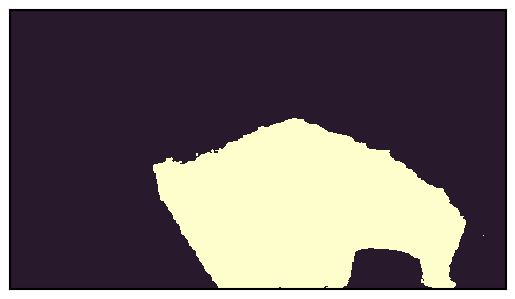

In [9]:
isns.imshow(np.transpose(masks, (1, 2, 0)))

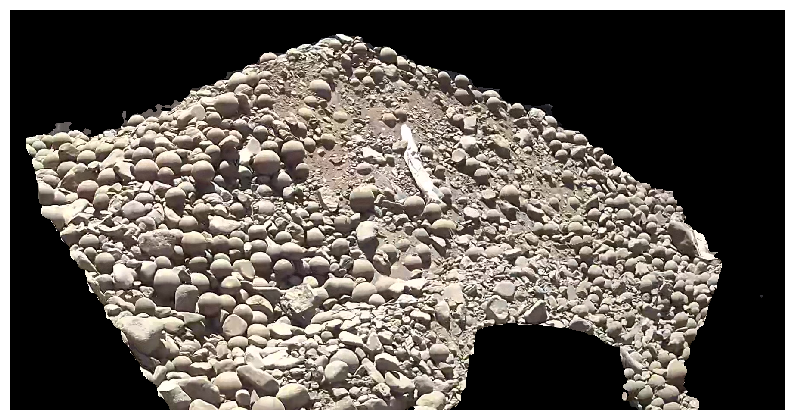

In [111]:
#input_box = np.array([700, 500, 2500, 1430])
x, y = box[0], box[1]
w, h = box[2] - box[0], box[3] - box[1]
result = image*np.transpose(masks, (1, 2, 0))
cropped_result = result[y:y+h, x:x+w]
plt.figure(figsize=(10, 10))
plt.imshow(cropped_result)
plt.axis('off')
plt.show()

second segmentation on region of interest

In [11]:
mask_generator_2 = SamAutomaticMaskGenerator(
    model=sam,
    points_per_side=32,
    pred_iou_thresh=0.86,
    stability_score_thresh=0.92,
    crop_n_layers=1,
    crop_n_points_downscale_factor=2,
    min_mask_region_area=100,  # Requires open-cv to run post-processing
)

In [12]:
masks2 = mask_generator_2.generate(cropped_result)

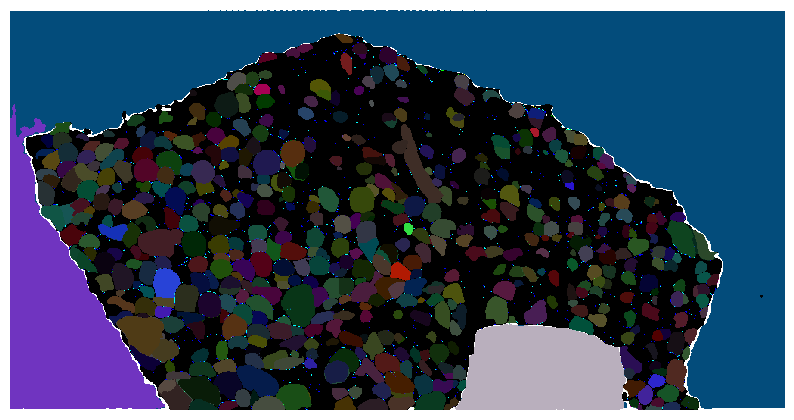

In [110]:
plt.figure(figsize=(10,10))
plt.imshow(cropped_result)
show_anns(masks2)
plt.axis('off')
plt.show() 

In [108]:
cropped_result.shape

(930, 1800, 3)

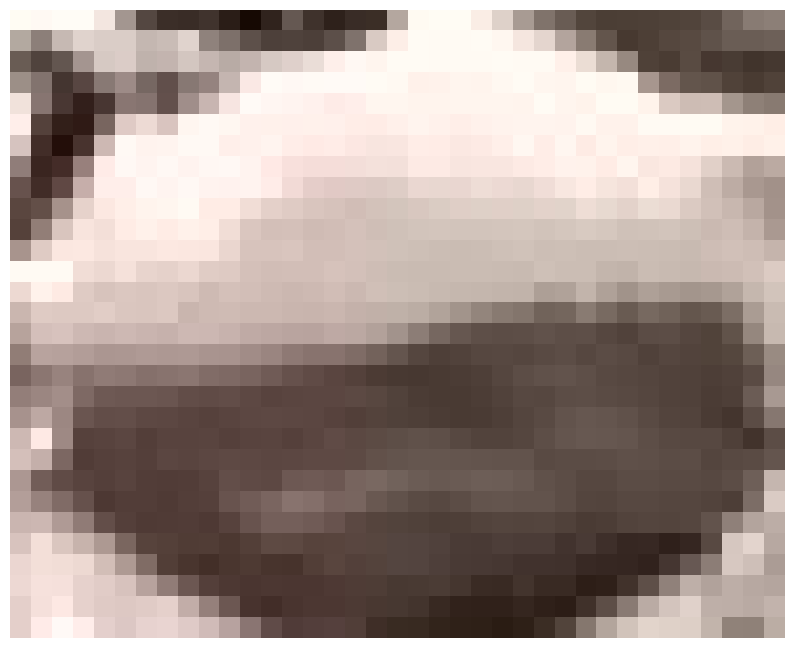

In [12]:
element = masks2[0]['bbox']
x, y, w, h = (e for e  in masks2[0]['bbox'])
img = cropped_result[y:(y+h), x:x+w]
plt.figure(figsize=(10,10))
plt.imshow(img)
plt.axis('off')
plt.show() 

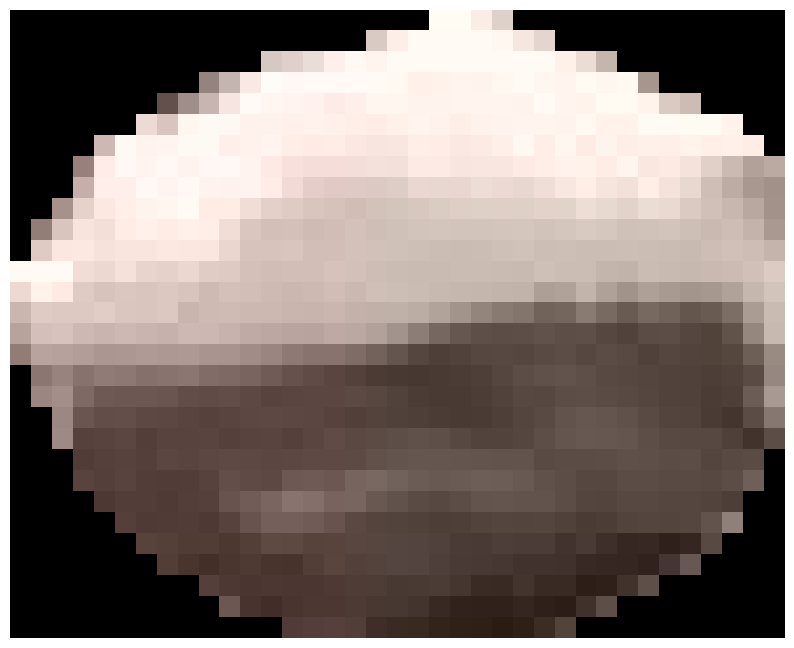

In [32]:
_mask = masks2[0]["segmentation"].reshape(930, 1800, 1)
x, y, w, h = (e for e  in masks2[0]['bbox'])
plt.figure(figsize=(10,10))
plt.imshow(_mask[y:(y+h), x:x+w] * cropped_result[y:(y+h), x:x+w])
plt.axis('off')
plt.show() 

In [165]:
def get_masks_image(masks, input_image):
    if len(masks) == 0:
        return
    
    sorted_anns = sorted(masks, key=(lambda x: x['area'] ), reverse=True)


    # Crear una imagen del mismo tamaño que la imagen de entrada
    img = np.ones((input_image.shape[0], input_image.shape[1], 4), dtype=np.uint8)
    img[:, :, 3] = 0  # Inicializar el canal alfa en cero
    
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.randint(0, 255, 3), [90]])  # Color aleatorio con opacidad 0.35
        img[m] = color_mask

    # Convertir la imagen de entrada a RGBA (añadir canal alfa)
    input_image_rgba = cv2.cvtColor(input_image, cv2.COLOR_BGR2BGRA)

    # Superponer la imagen generada por las anotaciones a la imagen de entrada
    output_image = cv2.addWeighted(input_image_rgba, 0.5, img, 0.5, 0)

    # Convertir la imagen de salida a BGR (eliminar canal alfa)
    output_image = cv2.cvtColor(output_image, cv2.COLOR_BGRA2BGR)

    return output_image


In [179]:
#filter masks
def filter_masks_by_area(masks, min_area=0, max_area=20000):
    return [ mask for mask in masks if min_area<= mask["area"] <= max_area ]



<Axes: >

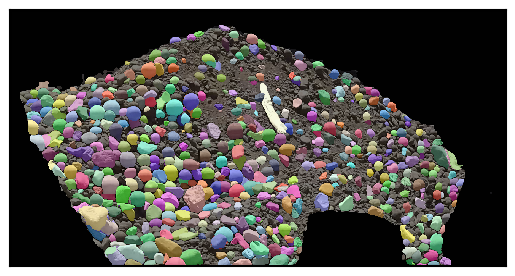

In [180]:
result = get_masks_image(filter_masks_by_area(masks2), copy.deepcopy(cropped_result))
isns.imshow(result)

In [181]:
fm = filter_masks_by_area(masks2)